In [23]:
import pandas as pd
import numpy as np
from textblob import TextBlob
# import wordcloud
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# from geopy.geocoders import Nominatim
from geotext import GeoText

import matplotlib.pyplot as plt

from collections import Counter
from datetime import datetime

import nltk

### Merge data from all months

In [16]:
# merge all month data
data_path = 'tweet_data'
files = os.listdir(data_path)
all_dfs = []
for i,f in enumerate(files):
    path = os.path.join(data_path, f)
    curr_df = pd.read_csv(path, encoding = "ISO-8859-1")
    all_dfs.append(curr_df)
all_dfs
big_df = pd.concat(all_dfs)
big_df.to_csv('other_data/all_tweets.csv')

In [17]:
big_df.shape

(131187, 15)

### Adding location columns

In [60]:
data = pd.read_csv('tweet_data/tweets_2020_08.csv')
data.head()

,tweet_id,location,date,likes,retweets,text
0,1298433064687763457,"Brooklyn, NY",2020-08-26,1458,861,Wearing a mask in public is an important way t...
1,1294720321392541696,"Sonoma, CA",2020-08-15,12739,4537,Canada shares a 5500 mile border with the US. ...
2,1296797780179144704,"Oakland, NJ",2020-08-21,310,58,The Braves and Nats got rained out yesterday. ...
3,1296941201111879692,"Fort Wayne, IN",2020-08-21,2,0,Purdue is kicking out anyone who dont go by so...
4,1289823031599087616,"Los Angeles, CA",2020-08-02,1979,695,The day camp my son went to was limited to 60 ...


In [24]:
state_abbrs = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
states = ["Alaska", "Alabama", "Arkansas", "American Samoa", 
            "Arizona", "California", "Colorado", "Connecticut", "District of Columbia",
            "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho", 
            "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", 
            "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", 
            "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", 
            "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", 
            "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", 
            "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", 
            "Wyoming"]
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
    
# invert the dictionary
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))
names_of_us = ['us','usa','united states','united states of america']

In [25]:
# testing geotext
places = GeoText('California, USA')
places.cities

[]

In [44]:
# function to add standardized location columns
def standardize_location(row):
      if row['index'] % 100 == 0:
            print('row ' + str(row['index']))
      # row['lower_location'] = row.location.lower()
      city = GeoText(row.location).cities # check if city in geotexts list of cities
      location_split = row.location.split(', ')
      if len(location_split) > 1:
            if location_split[1].lower() in names_of_us: # lower() for Usa, USA, etc.
                  row['city'] = 'Not City'
                  row['state'] = location_split[0]
                  row['is_state'] = True
            elif location_split[1].upper() in state_abbrs:
                  row['city'] = location_split[0]
                  row['state'] = abbrev_to_us_state.get(location_split[1].upper()) # upper() handles cases like: Ca, or tx
                  row['is_state'] = False
            elif city:
                  row['city'] = city[0]
                  row['state'] = location_split[1]
                  row['is_state'] = False
            else:
                  row['city'] = 'Not City'
                  row['state'] = location_split[0]
                  row['is_state'] = True
      else:
            row['city'] = 'Not City'
            row['state'] = location_split[0]
            row['is_state'] = False
      row['state_abbr'] = us_state_to_abbrev.get(row['state'])
      try:
            row['city_and_state'] = row['city'] + ', ' +  row['state']
      except:
            print(row, row['city'], row['state'], row['state_abbr'])
      return row

In [4]:
# creating test data from 4 months
# d1 = pd.read_csv('tweet_data/tweets_2020_04.csv')
# d2 = pd.read_csv('tweet_data/tweets_2020_08.csv')
# d3 = pd.read_csv('tweet_data/tweets_2020_12.csv')
# d4 = pd.read_csv('tweet_data/tweets_2021_04.csv')
# d2.head()
# pdList = [d1,d2,d3,d4]
# df_all = pd.concat(pdList)

In [45]:
df_all = pd.read_csv('other_data/all_tweets.csv')
df_all['index'] = range(1, len(df_all) + 1)
df_all2 = df_all.apply(lambda row: standardize_location(row),axis=1)
df_all2.head()

row 100
row 200
row 300
row 400
row 500
row 600
row 700
row 800
row 900
row 1000
row 1100
row 1200
row 1300
row 1400
row 1500
row 1600
row 1700
row 1800
row 1900
row 2000
row 2100
row 2200
row 2300
row 2400
row 2500
row 2600
row 2700
row 2800
row 2900
row 3000
row 3100
row 3200
row 3300
row 3400
row 3500
row 3600
row 3700
row 3800
row 3900
row 4000
row 4100
row 4200
row 4300
row 4400
row 4500
row 4600
row 4700
row 4800
row 4900
row 5000
row 5100
row 5200
row 5300
row 5400
row 5500
row 5600
row 5700
row 5800
row 5900
row 6000
row 6100
row 6200
row 6300
row 6400
row 6500
row 6600
row 6700
row 6800
row 6900
row 7000
row 7100
row 7200
row 7300
row 7400
row 7500
row 7600
row 7700
row 7800
row 7900
row 8000
row 8100
row 8200
row 8300
row 8400
row 8500
row 8600
row 8700
row 8800
row 8900
row 9000
row 9100
row 9200
row 9300
row 9400
row 9500
row 9600
row 9700
row 9800
row 9900
row 10000
row 10100
row 10200
row 10300
row 10400
row 10500
row 10600
row 10700
row 10800
row 10900
row 11000
row 1110

,tweet_id,location,date,likes,retweets,text,index,city,state,is_state,state_abbr,city_and_state
0,1.250000e+18,"Pomona, CA",4/4/2020,89921,34665,A day without Hispanics .... this country coul...,1,Pomona,California,False,CA,"Pomona, California"
1,1.250000e+18,"Santa Barbara, CA",4/21/2020,34308,5245,XO face masks are back to raise money and Iâ...,2,Santa Barbara,California,False,CA,"Santa Barbara, California"
2,1.250000e+18,"California, USA",4/21/2020,0,0,@ImKingGinger Well aren't you special? My rela...,3,Not City,California,True,CA,"Not City, California"
3,1.250000e+18,"Arizona, USA",4/19/2020,4,0,@seanhannity If I was to stay home and eat ice...,4,Not City,Arizona,True,AZ,"Not City, Arizona"
4,1.250000e+18,"Medford, MA",4/6/2020,0,0,"@MisagaLion @tedpanos Yup, CT. Governor spoke ...",5,Medford,Massachusetts,False,MA,"Medford, Massachusetts"


### Join mask data with twitter data

In [46]:
mask_data = pd.read_csv('mask_mandate_no_na_smaller.csv')
mask_data_sm = mask_data.iloc[:,[1,5,7]]
mask_data_sm = mask_data_sm.drop_duplicates()
mask_data_sm.head()

,State_Tribe_Territory,date,Face_Masks_Required_in_Public
0,AL,4/10/2020,No
1,AL,4/11/2020,No
2,AL,4/12/2020,No
3,AL,4/13/2020,No
4,AL,4/14/2020,No


In [32]:
mask_data_sm.loc[mask_data_sm.date == '8/17/2020',:].State_Tribe_Territory.unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'DC', 'FL', 'GA',
       'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA',
       'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY',
       'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'AS', 'GU', 'MP', 'PR',
       'VI'], dtype=object)

In [47]:
# df_all = pd.read_csv('tweet_data/model_test_data.csv')
# FOUND ISSUE: tweet data's date column has different formats Y-M-D and M/D/Y
# change all to /
df_all2['date'] = pd.to_datetime(df_all2['date']).dt.strftime('%#m/%#d/%Y')

In [48]:
df_all2.head()

,tweet_id,location,date,likes,retweets,text,index,city,state,is_state,state_abbr,city_and_state
0,1.250000e+18,"Pomona, CA",4/4/2020,89921,34665,A day without Hispanics .... this country coul...,1,Pomona,California,False,CA,"Pomona, California"
1,1.250000e+18,"Santa Barbara, CA",4/21/2020,34308,5245,XO face masks are back to raise money and Iâ...,2,Santa Barbara,California,False,CA,"Santa Barbara, California"
2,1.250000e+18,"California, USA",4/21/2020,0,0,@ImKingGinger Well aren't you special? My rela...,3,Not City,California,True,CA,"Not City, California"
3,1.250000e+18,"Arizona, USA",4/19/2020,4,0,@seanhannity If I was to stay home and eat ice...,4,Not City,Arizona,True,AZ,"Not City, Arizona"
4,1.250000e+18,"Medford, MA",4/6/2020,0,0,"@MisagaLion @tedpanos Yup, CT. Governor spoke ...",5,Medford,Massachusetts,False,MA,"Medford, Massachusetts"


In [49]:
# merge with mask mandate data
# mask_data_sm.iloc[:,0].unique() # no NA states
# mask_data_sm.iloc[:,2].unique() # no NA mandates, (all no, yes) 
# print(len(mask_data_sm.index),len(df_all.index)) # 27807 29053
# state_abbrs_freq = Counter(df_all['state_abbr']) # only 1171 none -> problem w join
# state_abbrs_freq
# mask_data_sm.head()
merged = df_all2.merge(mask_data_sm, how='left', 
                        left_on=['date','state_abbr'], 
                        right_on = ['date','State_Tribe_Territory'])
merged.head()

,tweet_id,location,date,likes,retweets,text,index,city,state,is_state,state_abbr,city_and_state,State_Tribe_Territory,Face_Masks_Required_in_Public
0,1.250000e+18,"Pomona, CA",4/4/2020,89921,34665,A day without Hispanics .... this country coul...,1,Pomona,California,False,CA,"Pomona, California",NaN,NaN
1,1.250000e+18,"Santa Barbara, CA",4/21/2020,34308,5245,XO face masks are back to raise money and Iâ...,2,Santa Barbara,California,False,CA,"Santa Barbara, California",CA,No
2,1.250000e+18,"California, USA",4/21/2020,0,0,@ImKingGinger Well aren't you special? My rela...,3,Not City,California,True,CA,"Not City, California",CA,No
3,1.250000e+18,"Arizona, USA",4/19/2020,4,0,@seanhannity If I was to stay home and eat ice...,4,Not City,Arizona,True,AZ,"Not City, Arizona",AZ,No
4,1.250000e+18,"Medford, MA",4/6/2020,0,0,"@MisagaLion @tedpanos Yup, CT. Governor spoke ...",5,Medford,Massachusetts,False,MA,"Medford, Massachusetts",NaN,NaN


In [50]:
merged.to_csv('merged_test_data.csv',index=False)

(array([1712.,  365.,  195.,  120.,  104.,   86.,   60.,   52.,   57.,
          37.,   27.,   46.,   34.,   32.,   25.,   22.,   30.,   29.,
          25.,   18.,   16.,   13.,   19.,   11.,   15.,   13.,   11.,
          14.,   12.,   14.,   14.,   11.,   10.,    8.,   12.,    8.,
          10.,    8.,   10.,   14.,    8.,    7.,   12.,    5.,    8.,
          10.,    5.,   10.,    6.,   14.]),
 array([ 0.  ,  1.98,  3.96,  5.94,  7.92,  9.9 , 11.88, 13.86, 15.84,
        17.82, 19.8 , 21.78, 23.76, 25.74, 27.72, 29.7 , 31.68, 33.66,
        35.64, 37.62, 39.6 , 41.58, 43.56, 45.54, 47.52, 49.5 , 51.48,
        53.46, 55.44, 57.42, 59.4 , 61.38, 63.36, 65.34, 67.32, 69.3 ,
        71.28, 73.26, 75.24, 77.22, 79.2 , 81.18, 83.16, 85.14, 87.12,
        89.1 , 91.08, 93.06, 95.04, 97.02, 99.  ]),
 <BarContainer object of 50 artists>)

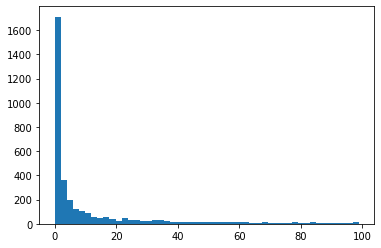

In [3]:
# check likes distribution
sub_data = data.loc[data['likes']<100,]
plt.hist(sub_data.likes,bins=50)

In [ ]:
# check likes distribution
sub_data = data.loc[data['likes']<100,]
plt.hist(sub_data.likes,bins=50)

In [8]:
# try text blob
data.text
for text in data.text[:5]:
    test_blob = TextBlob(text)
    print(test_blob.sentiment)

Sentiment(polarity=0.0, subjectivity=0.0)
Sentiment(polarity=0.0, subjectivity=0.0)
Sentiment(polarity=0.22809523809523807, subjectivity=0.6442857142857142)
Sentiment(polarity=0.26666666666666666, subjectivity=0.662962962962963)
Sentiment(polarity=-0.053787878787878794, subjectivity=0.5936868686868687)


### Add column to indicate whether mask mentioned

In [18]:
all_data = pd.read_csv('all_tweets_with_sentiment.csv')
all_data.head()

,tweet_id,location,date,likes,retweets,text,Polarity,Subjectivity
0,1.250000e+18,"Pomona, CA",4/4/2020,89921,34665,A day without Hispanics .... this country coul...,0.000000,0.000000
1,1.250000e+18,"Santa Barbara, CA",4/21/2020,34308,5245,XO face masks are back to raise money and Iâ...,0.000000,0.000000
2,1.250000e+18,"California, USA",4/21/2020,0,0,@ImKingGinger Well aren't you special? My rela...,0.228095,0.644286
3,1.250000e+18,"Arizona, USA",4/19/2020,4,0,@seanhannity If I was to stay home and eat ice...,0.266667,0.662963
4,1.250000e+18,"Medford, MA",4/6/2020,0,0,"@MisagaLion @tedpanos Yup, CT. Governor spoke ...",-0.053788,0.593687


In [ ]:
def has_mask(row):
    mask_words = ['mask','mandate','face']
    has_mask = any([phrase in row['text'] for phrase in mask_words])
    row['mentions_mask'] = has_mask
    return row

In [ ]:
df_all.head().apply(lambda row: has_mask(row),axis=1)

# tokenize text -> count for specific words

In [ ]:
# df_all2['text_tokens'] = df_all.apply(lambda row: has_mask(row),axis=1)
df_all2.apply(lambda row: nltk.word_tokenize(row['text']),axis=1)